In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

In [9]:
Z_SIZE = 4
HR_LEN = 30
GSR_LEN = 480
INPUT_SIZE = HR_LEN + GSR_LEN
FILTERED_USERS = ['Javi', 'Alexa', 'Levent']
device = torch.device("cpu")

# VAE code from: https://github.com/pytorch/examples/blob/master/vae/main.py

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(INPUT_SIZE, 256)
        self.fc21 = nn.Linear(256, Z_SIZE)
        self.fc22 = nn.Linear(256, Z_SIZE)
        self.fc3 = nn.Linear(Z_SIZE, 256)
        self.fc4 = nn.Linear(256, INPUT_SIZE)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, INPUT_SIZE))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, INPUT_SIZE), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, train_loader, optimizer, epoch, log_interval=1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(model, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [3]:
class ATDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super(ATDataset).__init__()
        self.data = torch.from_numpy(data.astype(np.float32))
    def __getitem__(self, index):
        return self.data[index]
    def __len__(self):
        return len(self.data)

def get_raw_data():
    import json
    from data_download import download_database
    raw_db = download_database()
    gsr_windows = []
    hr_windows = []
    for u in raw_db['users'].values():
        if u.get('first_name') not in FILTERED_USERS:
            continue
        for data_type in ['data', 'energy_data', 'quadrant_data']:
            data = u.get(data_type)
            if data is None:
                continue
            for entry in data.values():
                js_data = json.loads(entry['js_data'])
                snapshot = js_data['snapshot']
                gsr, hr = snapshot['gsr_samples'], snapshot['hr_samples']
                if len(gsr) > 0 and len(hr) > 0:
                    gsr_windows.append(gsr)
                    hr_windows.append(hr)
    assert len(gsr_windows) == len(hr_windows)
    return gsr_windows, hr_windows

def process_raw_data(gsr_windows, hr_windows, des_gsr_len, des_hr_len):
    assert len(gsr_windows) == len(hr_windows)
    N = len(gsr_windows)
    D = des_gsr_len + des_hr_len
    res = np.zeros((N, D))
    from scipy.signal import resample
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    for i in range(N):
        gsr = resample(gsr_windows[i], des_gsr_len)
        hr = resample(hr_windows[i], des_hr_len)
        assert gsr.size == des_gsr_len, hr.size == des_hr_len
        res[i, :des_gsr_len] = gsr
        res[i, des_gsr_len:] = hr
    res = scaler.fit_transform(res)
    return res, scaler

In [6]:
if 'data_' not in globals():
    gsr_windows_, hr_windows_ = get_raw_data()
    data_, scaler_ = process_raw_data(gsr_windows_, hr_windows_, 480, 30)
gsr_lens_ = [len(w) for w in gsr_windows_]
hr_lens_ = [len(w) for w in hr_windows_]
print(f'GSR mean window len: {np.mean(gsr_lens_)} (stdev: {np.std(gsr_lens_)})')
print(f'HR mean window len: {np.mean(hr_lens_)} (stdev: {np.std(hr_lens_)})')

GSR mean window len: 479.53846153846155 (stdev: 5.58118442726614)
HR mean window len: 42.494505494505496 (stdev: 27.063569295220884)


Train Epoch: 1 [0/136 (0%)]	Loss: 356.946564
Train Epoch: 1 [32/136 (20%)]	Loss: 335.897827
Train Epoch: 1 [64/136 (40%)]	Loss: 426.393036
Train Epoch: 1 [96/136 (60%)]	Loss: 283.749542
Train Epoch: 1 [32/136 (80%)]	Loss: 270.187317
====> Epoch: 1 Average loss: 346.0080
====> Test set loss: 248.8389


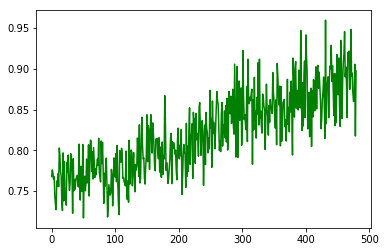

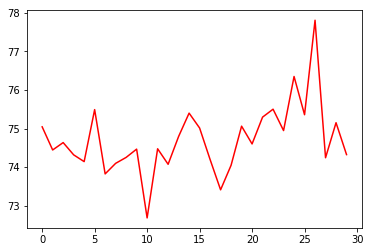

Train Epoch: 2 [0/136 (0%)]	Loss: 245.347015
Train Epoch: 2 [32/136 (20%)]	Loss: 154.545898
Train Epoch: 2 [64/136 (40%)]	Loss: 124.096245
Train Epoch: 2 [96/136 (60%)]	Loss: 130.733566
Train Epoch: 2 [32/136 (80%)]	Loss: -101.796005
====> Epoch: 2 Average loss: 148.0644
====> Test set loss: -198.6432


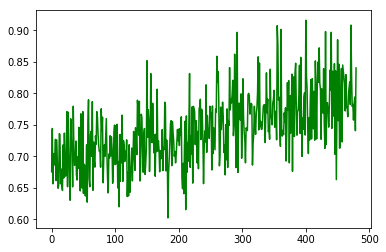

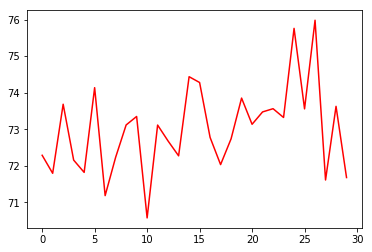

Train Epoch: 3 [0/136 (0%)]	Loss: -296.492615
Train Epoch: 3 [32/136 (20%)]	Loss: -69.070938
Train Epoch: 3 [64/136 (40%)]	Loss: -597.484863
Train Epoch: 3 [96/136 (60%)]	Loss: -372.750244
Train Epoch: 3 [32/136 (80%)]	Loss: -264.560516
====> Epoch: 3 Average loss: -329.8680
====> Test set loss: -1038.2276


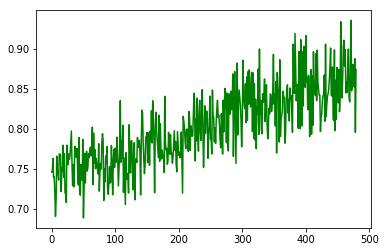

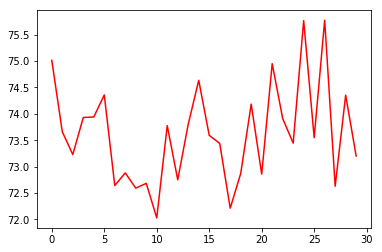

Train Epoch: 4 [0/136 (0%)]	Loss: -1057.569336
Train Epoch: 4 [32/136 (20%)]	Loss: -905.104675
Train Epoch: 4 [64/136 (40%)]	Loss: -1512.922974
Train Epoch: 4 [96/136 (60%)]	Loss: -1747.764771
Train Epoch: 4 [32/136 (80%)]	Loss: -1522.592407
====> Epoch: 4 Average loss: -1318.5906
====> Test set loss: -3015.4805


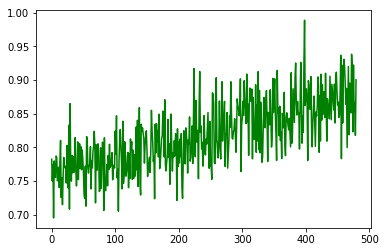

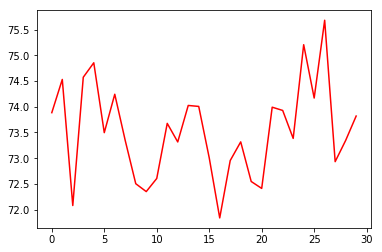

Train Epoch: 5 [0/136 (0%)]	Loss: -3033.037598
Train Epoch: 5 [32/136 (20%)]	Loss: -2626.057861
Train Epoch: 5 [64/136 (40%)]	Loss: -2487.384033
Train Epoch: 5 [96/136 (60%)]	Loss: -3354.640625
Train Epoch: 5 [32/136 (80%)]	Loss: -2987.748047
====> Epoch: 5 Average loss: -2881.8958
====> Test set loss: -5410.4389


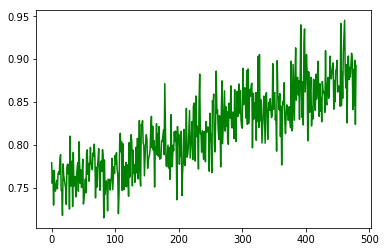

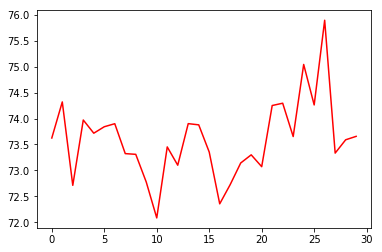

Train Epoch: 6 [0/136 (0%)]	Loss: -4193.029785
Train Epoch: 6 [32/136 (20%)]	Loss: -4585.252930
Train Epoch: 6 [64/136 (40%)]	Loss: -5945.490723
Train Epoch: 6 [96/136 (60%)]	Loss: -5782.007324
Train Epoch: 6 [32/136 (80%)]	Loss: -1963.838257
====> Epoch: 6 Average loss: -4940.4095
====> Test set loss: -8552.1185


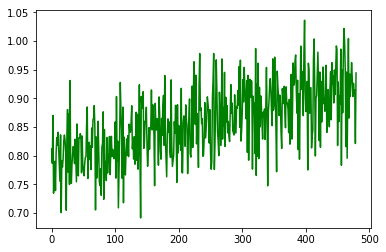

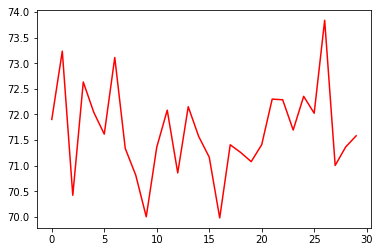

Train Epoch: 7 [0/136 (0%)]	Loss: -4264.464355
Train Epoch: 7 [32/136 (20%)]	Loss: -5617.804688
Train Epoch: 7 [64/136 (40%)]	Loss: -10369.579102
Train Epoch: 7 [96/136 (60%)]	Loss: -8613.893555
Train Epoch: 7 [32/136 (80%)]	Loss: -7646.588867
====> Epoch: 7 Average loss: -7241.7386
====> Test set loss: -10228.6158


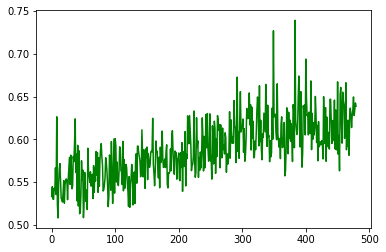

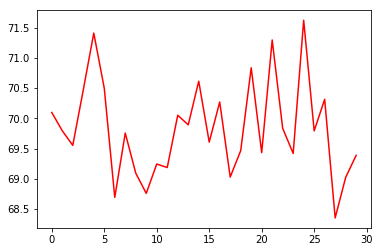

Train Epoch: 8 [0/136 (0%)]	Loss: -6786.565430
Train Epoch: 8 [32/136 (20%)]	Loss: -6650.021484
Train Epoch: 8 [64/136 (40%)]	Loss: -11658.501953
Train Epoch: 8 [96/136 (60%)]	Loss: -7730.375488
Train Epoch: 8 [32/136 (80%)]	Loss: -4395.801758
====> Epoch: 8 Average loss: -7982.2152
====> Test set loss: -10367.2086


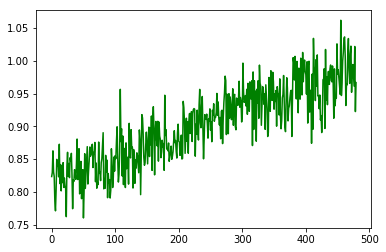

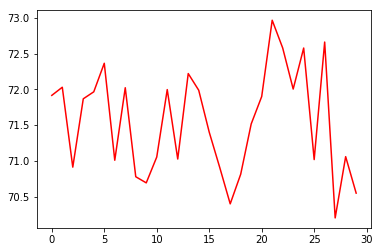

Train Epoch: 9 [0/136 (0%)]	Loss: -7595.236816
Train Epoch: 9 [32/136 (20%)]	Loss: -5876.749023
Train Epoch: 9 [64/136 (40%)]	Loss: -9724.215820
Train Epoch: 9 [96/136 (60%)]	Loss: -8174.194336
Train Epoch: 9 [32/136 (80%)]	Loss: -8106.605957
====> Epoch: 9 Average loss: -7858.1288
====> Test set loss: -9761.1979


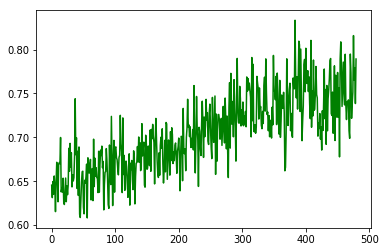

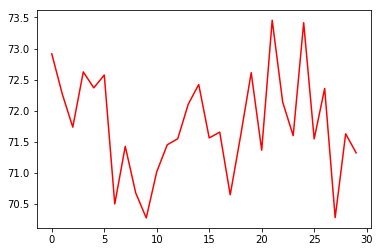

Train Epoch: 10 [0/136 (0%)]	Loss: -7132.725586
Train Epoch: 10 [32/136 (20%)]	Loss: -9150.833008
Train Epoch: 10 [64/136 (40%)]	Loss: -6402.351562
Train Epoch: 10 [96/136 (60%)]	Loss: -6826.694824
Train Epoch: 10 [32/136 (80%)]	Loss: -3420.654541
====> Epoch: 10 Average loss: -7145.3573
====> Test set loss: -8489.7099


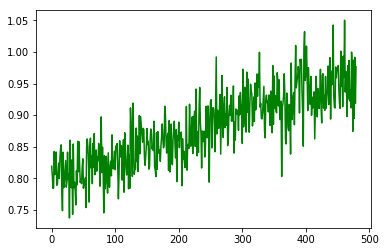

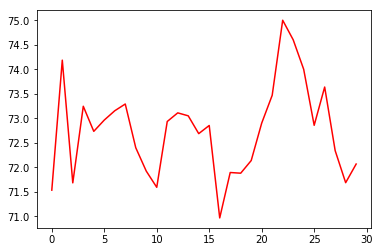

In [8]:
def main():
    torch.manual_seed(42)
    
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    batch_size = 32
    epochs = 10
    
    x_train, x_test = train_test_split(data_, test_size=0.25)
    train_ds = ATDataset(x_train)
    test_ds = ATDataset(x_test)
    
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)
    
    for epoch in range(1, epochs + 1):
        train(model, train_loader, optimizer, epoch)
        test(model, test_loader, epoch)
        with torch.no_grad():
            sample = torch.randn(1, Z_SIZE).to(device)
            sample = model.decode(sample).cpu().numpy()
            sample = scaler_.inverse_transform(sample)

            plt.figure()
            plt.plot(sample[0, :480], color='g')
            plt.show()
            plt.figure()
            plt.plot(sample[0, 480:], color='r')
            plt.show()
main()